# Processing Saint Louis Data

In [1]:
import os
import numpy as np
import patoolib
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# make the working directory as pwd
os.chdir('/Users/sbhadra/GIS5120-dev')

## Figure out the analysis boundary

The analysis boundary would be the Saint Louis County and Saint Louis City. I downloaded the US County shapefile from TIGER [https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip](https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip).

In [3]:
# read us county shape
county = gpd.read_file('labs/lab-2/data/shapes/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')

<Axes: >

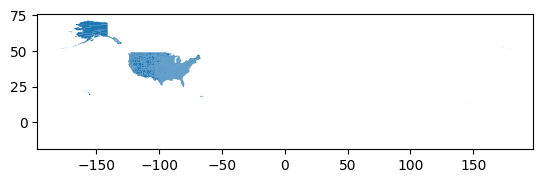

In [4]:
county.plot()

In [5]:
county.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.0463, -89.17938 37.0530..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.6454, -84.12483 37.6461..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


I know that the two counties I am looking for are `St.Louis`. Let's find that.

In [6]:
stl_county = county[county['NAME']=='St. Louis']

In [7]:
stl_county

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
111,29,189,00758549,0500000US29189,29189,St. Louis,06,1314228662,40161918,"POLYGON ((-90.73643 38.46985, -90.73614 38.477..."
1078,27,137,00662850,0500000US27137,27137,St. Louis,06,16181664972,1584404426,"POLYGON ((-93.09767 48.24247, -93.09481 48.242..."
1697,29,510,00767557,0500000US29510,29510,St. Louis,25,159915148,11211123,"POLYGON ((-90.32052 38.59415, -90.31904 38.597..."


It returned three counties, but it should be just 2. See that the STATEFP codes are 27 and 29. So maybe the St. Louis counties we are looking for are under STATEFP of 29.

In [8]:
stl_county = stl_county[stl_county['STATEFP']=='29']

<Axes: >

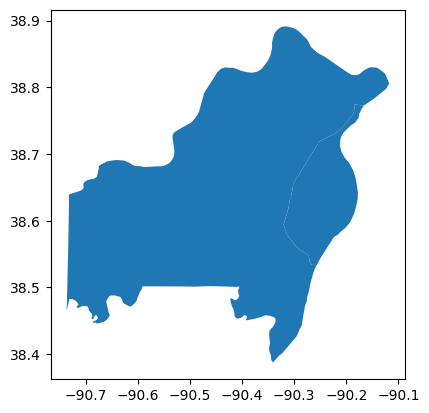

In [9]:
stl_county.plot()

Let's dissolve the both counties together.

In [10]:
aoi = stl_county.dissolve(by='NAME')

## Crime data

Crime data was downloaded from [https://slmpd.org/wp-content/uploads/2024/03/2021-2023.csv](https://slmpd.org/wp-content/uploads/2024/03/2021-2023.csv) as csv file.

In [11]:
# read data
crime_data = pd.read_csv('labs/lab-2/data/2021-2023.csv')

/var/folders/tv/sv5cjn651pl0ls89b33pwkjw0000gn/T/ipykernel_85098/2694204020.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_data = pd.read_csv('labs/lab-2/data/2021-2023.csv')


In [12]:
# filter data that has lat and long
# first find the index that has latitude and longitide data
latlon_idx = crime_data[['Latitude', 'Longitude']].dropna()
# use that index to filter the df data, also reset index
crime_data = crime_data.loc[latlon_idx.index, :].reset_index(drop=True)

In [13]:
crime_data

,IncidentDate,OccurredFromTime,IncidentNum,Offense,NIBRS,NIBRSCategory,SRS_UCR,CrimeAgainst,FelMisdCit,IncidentTopSRS_UCR,...,District,Neighborhood,NbhdNum,Latitude,Longitude,IncidentSupplemented,LastSuppDate,VictimNum,FirearmUsed,IncidentNature
0,2021-01-13,00:01:00,19007979,FAIL TO REGISTER AS A SEX OFFENDER PURSUANT TO...,90Z,All Other Offenses,NaN,Unspecified,F,NaN,...,4.0,Downtown West,36,38.632110,-90.207689,Yes,2023-09-19 10:18:30.0930000,NaN,No,Offenses - All Other - Criminal
1,2023-08-28,00:10:00,19028410,STEALING - MOTOR VEHICLE/WATERCRAFT/AIRCRAFT &...,240,Motor Vehicle Theft,7.0,Property,F,7.0,...,4.0,Downtown West,36,38.633575,-90.210773,No,NaN,NaN,No,Motor Vehicle Theft - Criminal
2,2021-10-26,10:30:00,19035349,STEALING - MOTOR VEHICLE/WATERCRAFT/AIRCRAFT,240,Motor Vehicle Theft,7.0,Property,F,7.0,...,2.0,Southampton,7,38.594193,-90.292975,Yes,2021-11-01 10:38:08.0000000,NaN,No,Motor Vehicle Theft - Criminal
3,2021-10-26,10:30:00,19035349,STEALING,26A,False Pretense/Swindle/Confidence Game,NaN,Property,M,7.0,...,2.0,Southampton,7,38.594193,-90.292975,Yes,2021-11-01 10:38:08.0000000,NaN,No,Motor Vehicle Theft - Criminal
4,2021-06-25,15:30:00,19043826,STEALING,23H,All Other Larceny,6.0,Property,F,6.0,...,5.0,West End,48,38.661280,-90.289470,No,NaN,NaN,No,Stolen Property - Criminal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178027,2023-12-17,13:00:00,24007193,ENDANGERING THE WELFARE OF A CHILD INVOLVING D...,90F,"Family Offenses, Nonviolent",NaN,Society,F,NaN,...,6.0,Walnut Park East,72,38.697033,-90.258690,No,NaN,NaN,No,Non-Violent Family Offense - Criminal
178028,2023-07-05,15:00:00,24007204,STEALING UNDER $150 (PETTY LARCENY-MOTOR VEH P...,23G,Theft From Motor Vehicle Parts/Accessories,6.0,Property,NaN,6.0,...,1.0,Dutchtown,16,38.579416,-90.246300,No,NaN,NaN,No,Larceny - Criminal
178029,2022-06-01,12:00:00,24007219,IDENTITY THEFT OR ATTEMPT,26F,Identity Theft,NaN,Property,F,NaN,...,5.0,Wells Goodfellow,50,38.670034,-90.265111,No,NaN,NaN,No,Fraud - Criminal
178030,2023-11-20,12:00:00,24007475,STEALING UNDER $150 (PETTY LARCENY - FROM MOTO...,23F,Theft From Motor Vehicle,6.0,Property,NaN,6.0,...,2.0,Tower Grove South,15,38.592700,-90.263290,No,NaN,NaN,No,Larceny - Criminal


In [14]:
# create a GeoDataFrame, converting the lat/lon into a Point geometry
crime_data = gpd.GeoDataFrame(
    crime_data, 
    geometry=gpd.points_from_xy(crime_data['Longitude'], crime_data['Latitude']),
    crs='EPSG:4326'
)

In [15]:
crime_data.columns

Index(['IncidentDate', 'OccurredFromTime', 'IncidentNum', 'Offense', 'NIBRS',
       'NIBRSCategory', 'SRS_UCR', 'CrimeAgainst', 'FelMisdCit',
       'IncidentTopSRS_UCR', 'IncidentLocation', 'IntersectionOtherLoc',
       'District', 'Neighborhood', 'NbhdNum', 'Latitude', 'Longitude',
       'IncidentSupplemented', 'LastSuppDate', 'VictimNum', 'FirearmUsed',
       'IncidentNature', 'geometry'],
      dtype='object')

In [16]:
# select only related columns
crime_data = crime_data[
    [
        'IncidentDate', 'IncidentNature', 'geometry'
    ]
]

In [17]:
# rename columns
crime_data = crime_data.rename(
    columns={
        'IncidentDate': 'Date',
        'IncidentNature': 'Nature'
    }
)

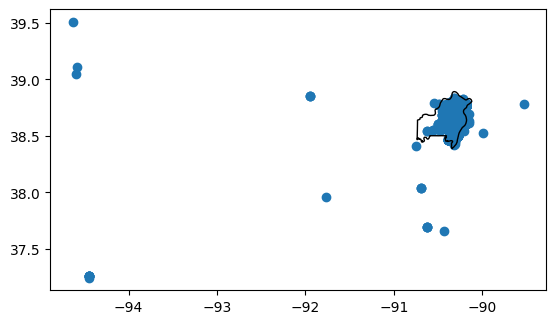

In [18]:
fig, ax = plt.subplots()

crime_data.plot(ax=ax)
aoi.plot(ax=ax, facecolor='none', edgecolor='black')

plt.show()

Let's clip the crime data to aoi boundary. But first, check both the shapes crs and make sure they are same.

In [19]:
aoi.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [20]:
crime_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
# change aoi crs to 4326
aoi = aoi.to_crs('EPSG:4326')

In [22]:
crime_data = gpd.clip(crime_data, aoi)

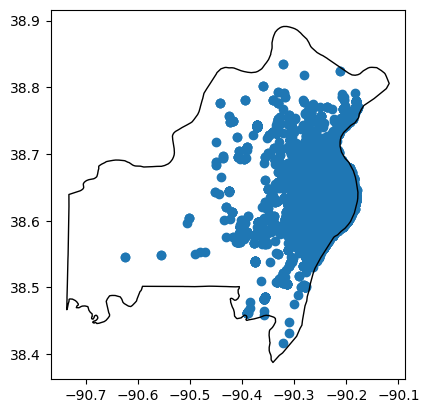

In [23]:
fig, ax = plt.subplots()

crime_data.plot(ax=ax)
aoi.plot(ax=ax, facecolor='none', edgecolor='black')

plt.show()

## Liquor data

Liquor data was downloaded from [https://data.mo.gov/Regulatory/Missouri-Active-Alcohol-License-Data/yyhn-562y/about_data](https://data.mo.gov/Regulatory/Missouri-Active-Alcohol-License-Data/yyhn-562y/about_data).

In [24]:
# read liquor data
liquors = pd.read_csv('labs/lab-2/data/Missouri_Active_Alcohol_License_Data_20240902.csv')

In [25]:
liquors.head()

,LICENSEE,DBANAME,STREET NUMBER,STREET,CITY,STATE,ZIPCODE,PHONE NUMBER,PRIMARY LICENSE,SECONDARY LICENSE,PRIMARY TYPE,SECONDARY TYPE,COUNTY,DISTRICT,SUBDIST,LATLNG,Assoc,First Name,Last Name,Phone
0,CONVENTION HOSPITALITY PARTNERS,CONVENTION HOSPITALITY PARTNERS,701,CONVENTION PLAZA-TERRACE LEVEL,ST. LOUIS,MO,63101,3143425036,242415,242416,RBD,SBD,ST. LOUIS CITY,3,0,NaN,PART,ANDREW,LANSING,3123355031
1,LEVY PREMIUM FOOD SERVICE LIMITED PART.,SCOTTRADE CENTER-LEVEL 1 & SUMMER GARDEN,1401,CLARK AVE.,ST. LOUIS,MO,63104,3146225400,177624,238642,RBD,RDC1,ST. LOUIS CITY,3,0,"(38.626175, -90.202131)",PART,ANDREW,LANSING,3123355031
2,"LUXCO, INC.",PARAMOUNT DISTILLERS,3116,BEREA ROAD,CLEVELAND,OH,441111501,3147722626,280041,0,LS,NaN,OUT OF STATE,7,0,NaN,MGR,DAVID,BRATCHER,3143081047
3,CONVENTION HOSPITALITY PARTNERS,CONVENTION HOSPITALITY PARTMERS,701,CONVENTION PLAZA-SUITE LEVEL,ST. LOUIS,MO,63101,3143425036,242421,242422,RBD,SBD,ST. LOUIS CITY,3,0,NaN,PART,ANDREW,LANSING,3123355031
4,LEVY PREMIUM FOOD SERVICE LIMITED PART.,SCOTTRADE CENTER-THIRD LEVEL,1401,CLARK AVE.,ST. LOUIS,MO,63104,3146225400,177628,177629,RBD,SBD,ST. LOUIS CITY,3,0,"(38.626175, -90.202131)",PART,ANDREW,LANSING,3123355031


In [26]:
# remove any rows that does not have LATLNG data
latlon_idx = liquors[['LATLNG']].dropna()

In [27]:
# filter data that has lat and long
# first find the index that has latitude and longitide data
latlon_idx = liquors[['LATLNG']].dropna()
# use that index to filter the df data, also reset index
liquors = liquors.loc[latlon_idx.index, :].reset_index(drop=True)

In [28]:
liquors['LATLNG']

0                (38.626175, -90.202131)
1                (38.626175, -90.202131)
2         (38.92673, -94.40713199999999)
3              (36.6579977, -93.2718034)
4                (38.626175, -90.202131)
                      ...               
5556           (39.2455871, -94.4570865)
5557    (39.0104366, -94.30639930000001)
5558             (38.590624, -90.257897)
5559            (38.710826, -90.8770732)
5560    (39.4492488, -91.04960520000002)
Name: LATLNG, Length: 5561, dtype: object

In [29]:
# split the 'latlon' column into separate 'lat' and 'lon' columns
liquors[['lat', 'lon']] = liquors['LATLNG'].str.extract(r'\(([^,]+), ([^,]+)\)').astype(float)

In [30]:
liquors

,LICENSEE,DBANAME,STREET NUMBER,STREET,CITY,STATE,ZIPCODE,PHONE NUMBER,PRIMARY LICENSE,SECONDARY LICENSE,...,COUNTY,DISTRICT,SUBDIST,LATLNG,Assoc,First Name,Last Name,Phone,lat,lon
0,LEVY PREMIUM FOOD SERVICE LIMITED PART.,SCOTTRADE CENTER-LEVEL 1 & SUMMER GARDEN,1401,CLARK AVE.,ST. LOUIS,MO,63104,3146225400,177624,238642,...,ST. LOUIS CITY,3,0,"(38.626175, -90.202131)",PART,ANDREW,LANSING,3123355031,38.626175,-90.202131
1,LEVY PREMIUM FOOD SERVICE LIMITED PART.,SCOTTRADE CENTER-THIRD LEVEL,1401,CLARK AVE.,ST. LOUIS,MO,63104,3146225400,177628,177629,...,ST. LOUIS CITY,3,0,"(38.626175, -90.202131)",PART,ANDREW,LANSING,3123355031,38.626175,-90.202131
2,MMG MISSOURI LLC,CHILI'S GRILL & BAR,1688,NW CHIPMAN RD,LEE'S SUMMIT,MO,64081,9729662221,186472,186473,...,JACKSON,1,0,"(38.92673, -94.40713199999999)",MGR,KENT,COXE,8164210644,38.926730,-94.407132
3,WESTGATE GV AT THE WOODS LLC,WESTGATE BRANSON,2201,ROARK VALLEY ROAD,BRANSON,MO,656168122,4173342324,242128,242130,...,TANEY,5,0,"(36.6579977, -93.2718034)",MGR,BRIAN,GRABOWSKI,3212298189,36.657998,-93.271803
4,LEVY PREMIUM FOOD SERVICE LIMITED PART.,SCOTTRADE CENTER-FOURTH LEVEL,1401,CLARK AVE.,ST. LOUIS,MO,63104,3146225400,177622,177623,...,ST. LOUIS CITY,3,0,"(38.626175, -90.202131)",PART,ANDREW,LANSING,3123355031,38.626175,-90.202131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5556,APPLE NINE HOSPITALITY MANAGEMENT INC.,HAMPTON INN KANSAS CITY-LIBERTY,8551,N. CHURCH ROAD,KANSAS CITY,MO,64157,8164159600,252296,252297,...,CLAY,1,0,"(39.2455871, -94.4570865)",MGR,GLENN,KOCH,8163082598,39.245587,-94.457087
5557,M. WILSON & V. WILSON LLC,WATER'S EDGE BAR & GRILL,960,S.W. 37TH ST.,BLUE SPRINGS,MO,640157400,8162240595,156897,156898,...,JACKSON,1,0,"(39.0104366, -94.30639930000001)",MGR,MARK,WILSON,8162240002,39.010437,-94.306399
5558,CIVIL LIFE BREWING COMPANY LLC,CIVIL LIFE BREWING COMPANY,3714,HOLT AVENUE,ST. LOUIS,MO,631162614,3144949800,208905,296994,...,ST. LOUIS CITY,3,0,"(38.590624, -90.257897)",MGR,JACOB,HAFNER,3144949800,38.590624,-90.257897
5559,IMMACULATE HEART OF MARY CATHOLIC CHURCH,IMMACULATE HEART OF MARY CATHOLIC CHURCH,8,W. HWY D,NEW MELLE,MO,63365,6363985270,276161,0,...,ST. CHARLES,3,0,"(38.710826, -90.8770732)",MGR,ANDREW,BURKEMPER,6363985270,38.710826,-90.877073


In [31]:
# create a GeoDataFrame, converting the lat/lon into a Point geometry
liquors = gpd.GeoDataFrame(
    liquors, 
    geometry=gpd.points_from_xy(liquors['lon'], liquors['lat']),
    crs='EPSG:4326'
)

In [32]:
liquors.head()

,LICENSEE,DBANAME,STREET NUMBER,STREET,CITY,STATE,ZIPCODE,PHONE NUMBER,PRIMARY LICENSE,SECONDARY LICENSE,...,DISTRICT,SUBDIST,LATLNG,Assoc,First Name,Last Name,Phone,lat,lon,geometry
0,LEVY PREMIUM FOOD SERVICE LIMITED PART.,SCOTTRADE CENTER-LEVEL 1 & SUMMER GARDEN,1401,CLARK AVE.,ST. LOUIS,MO,63104,3146225400,177624,238642,...,3,0,"(38.626175, -90.202131)",PART,ANDREW,LANSING,3123355031,38.626175,-90.202131,POINT (-90.20213 38.62618)
1,LEVY PREMIUM FOOD SERVICE LIMITED PART.,SCOTTRADE CENTER-THIRD LEVEL,1401,CLARK AVE.,ST. LOUIS,MO,63104,3146225400,177628,177629,...,3,0,"(38.626175, -90.202131)",PART,ANDREW,LANSING,3123355031,38.626175,-90.202131,POINT (-90.20213 38.62618)
2,MMG MISSOURI LLC,CHILI'S GRILL & BAR,1688,NW CHIPMAN RD,LEE'S SUMMIT,MO,64081,9729662221,186472,186473,...,1,0,"(38.92673, -94.40713199999999)",MGR,KENT,COXE,8164210644,38.926730,-94.407132,POINT (-94.40713 38.92673)
3,WESTGATE GV AT THE WOODS LLC,WESTGATE BRANSON,2201,ROARK VALLEY ROAD,BRANSON,MO,656168122,4173342324,242128,242130,...,5,0,"(36.6579977, -93.2718034)",MGR,BRIAN,GRABOWSKI,3212298189,36.657998,-93.271803,POINT (-93.2718 36.658)
4,LEVY PREMIUM FOOD SERVICE LIMITED PART.,SCOTTRADE CENTER-FOURTH LEVEL,1401,CLARK AVE.,ST. LOUIS,MO,63104,3146225400,177622,177623,...,3,0,"(38.626175, -90.202131)",PART,ANDREW,LANSING,3123355031,38.626175,-90.202131,POINT (-90.20213 38.62618)


In [33]:
# only pick related columns
liquors = liquors[
    [
        'LICENSEE', 'DBANAME', 'STREET NUMBER', 'STREET', 'CITY', 'STATE',
        'ZIPCODE', 'PRIMARY LICENSE', 'SECONDARY LICENSE', 'PRIMARY TYPE', 
        'SECONDARY TYPE', 'COUNTY', 'DISTRICT', 'SUBDIST', 'Assoc',
        'geometry'
    ]
]

In [34]:
# rename column names
liquors = liquors.rename(
    columns={
        'STREET NUMBER': 'STREET_NUM', 
        'PRIMARY LICENSE': 'PRIM_LIC', 
        'SECONDARY LICENSE': 'SEC_LIC', 
        'PRIMARY TYPE': 'PRIM_TYP', 
        'SECONDARY TYPE': 'SEC_TYP'
    }
)

In [35]:
liquors

,LICENSEE,DBANAME,STREET_NUM,STREET,CITY,STATE,ZIPCODE,PRIM_LIC,SEC_LIC,PRIM_TYP,SEC_TYP,COUNTY,DISTRICT,SUBDIST,Assoc,geometry
0,LEVY PREMIUM FOOD SERVICE LIMITED PART.,SCOTTRADE CENTER-LEVEL 1 & SUMMER GARDEN,1401,CLARK AVE.,ST. LOUIS,MO,63104,177624,238642,RBD,RDC1,ST. LOUIS CITY,3,0,PART,POINT (-90.20213 38.62618)
1,LEVY PREMIUM FOOD SERVICE LIMITED PART.,SCOTTRADE CENTER-THIRD LEVEL,1401,CLARK AVE.,ST. LOUIS,MO,63104,177628,177629,RBD,SBD,ST. LOUIS CITY,3,0,PART,POINT (-90.20213 38.62618)
2,MMG MISSOURI LLC,CHILI'S GRILL & BAR,1688,NW CHIPMAN RD,LEE'S SUMMIT,MO,64081,186472,186473,RBD,SBD,JACKSON,1,0,MGR,POINT (-94.40713 38.92673)
3,WESTGATE GV AT THE WOODS LLC,WESTGATE BRANSON,2201,ROARK VALLEY ROAD,BRANSON,MO,656168122,242128,242130,OPL,OPT,TANEY,5,0,MGR,POINT (-93.2718 36.658)
4,LEVY PREMIUM FOOD SERVICE LIMITED PART.,SCOTTRADE CENTER-FOURTH LEVEL,1401,CLARK AVE.,ST. LOUIS,MO,63104,177622,177623,RBD,SBD,ST. LOUIS CITY,3,0,PART,POINT (-90.20213 38.62618)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5556,APPLE NINE HOSPITALITY MANAGEMENT INC.,HAMPTON INN KANSAS CITY-LIBERTY,8551,N. CHURCH ROAD,KANSAS CITY,MO,64157,252296,252297,RBD,SBD,CLAY,1,0,MGR,POINT (-94.45709 39.24559)
5557,M. WILSON & V. WILSON LLC,WATER'S EDGE BAR & GRILL,960,S.W. 37TH ST.,BLUE SPRINGS,MO,640157400,156897,156898,RBD,SBD,JACKSON,1,0,MGR,POINT (-94.3064 39.01044)
5558,CIVIL LIFE BREWING COMPANY LLC,CIVIL LIFE BREWING COMPANY,3714,HOLT AVENUE,ST. LOUIS,MO,631162614,208905,296994,RBD,SBD,ST. LOUIS CITY,3,0,MGR,POINT (-90.2579 38.59062)
5559,IMMACULATE HEART OF MARY CATHOLIC CHURCH,IMMACULATE HEART OF MARY CATHOLIC CHURCH,8,W. HWY D,NEW MELLE,MO,63365,276161,0,COL,NaN,ST. CHARLES,3,0,MGR,POINT (-90.87707 38.71083)


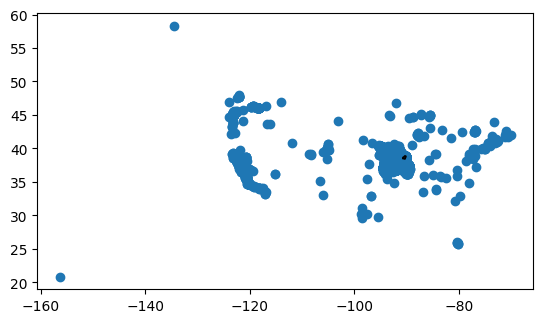

In [36]:
fig, ax = plt.subplots()

liquors.plot(ax=ax)
aoi.plot(ax=ax, facecolor='none', edgecolor='black')

plt.show()

In [37]:
liquors = gpd.clip(liquors, aoi)

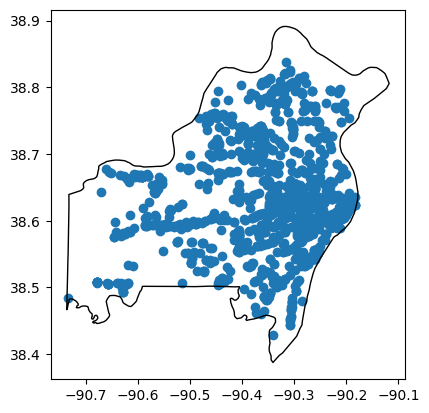

In [38]:
fig, ax = plt.subplots()

liquors.plot(ax=ax)
aoi.plot(ax=ax, facecolor='none', edgecolor='black')

plt.show()

## Poverty data

Download the poverty data by using the US Census API. We will download it at block groups for two st louis counties. Learn more about how to use the Census api [here](https://libguides.brown.edu/census/api). Here is the url we will need to access. We will use the `requests` to get the response from the url and save it into a dataframe. For poverty data, we need the median household information in each block group and that is available in the `B19013_001E` table.

In [39]:
# variables for census data
year = '2020'
dsource = 'acs' # american community survey
dname = 'acs5' # 5 year estimate table
cols = 'B19013_001E,NAME'
state = '29' # MO FIPS
county = '189,510' # St Louis City and County FIPS
api_key = 'e888fbaaba4e0a1a6b33872f0267a266548edd0f'

In [40]:
# base url
base_url = f"https://api.census.gov/data/{year}/{dsource}/{dname}"
data_url = f"{base_url}?get={cols}&for=block%20group:*&in=state:{state}%20county:{county}&key={api_key}"

In [41]:
# Request data
response = requests.get(data_url)
data = response.json()

In [71]:
# convert to pandas DataFrame
income_data = pd.DataFrame(data[1:], columns=data[0])

In [72]:
income_data

,B19013_001E,NAME,state,county,tract,block group
0,25321,"Block Group 1, Census Tract 2101.02, St. Louis...",29,189,210102,1
1,34471,"Block Group 1, Census Tract 2102, St. Louis Co...",29,189,210200,1
2,30676,"Block Group 4, Census Tract 2102, St. Louis Co...",29,189,210200,4
3,47806,"Block Group 3, Census Tract 2103, St. Louis Co...",29,189,210300,3
4,66271,"Block Group 2, Census Tract 2104, St. Louis Co...",29,189,210400,2
...,...,...,...,...,...,...
1057,96645,"Block Group 3, Census Tract 2219, St. Louis Co...",29,189,221900,3
1058,55089,"Block Group 1, Census Tract 2220, St. Louis Co...",29,189,222000,1
1059,99125,"Block Group 2, Census Tract 2220, St. Louis Co...",29,189,222000,2
1060,142500,"Block Group 2, Census Tract 2221, St. Louis Co...",29,189,222100,2


Everything here is converted from string data. So the income is in string format. Let's convert it to int.

In [74]:
income_data['B19013_001E'] = income_data['B19013_001E'].astype('int')

Let's check the histogram of the income data.

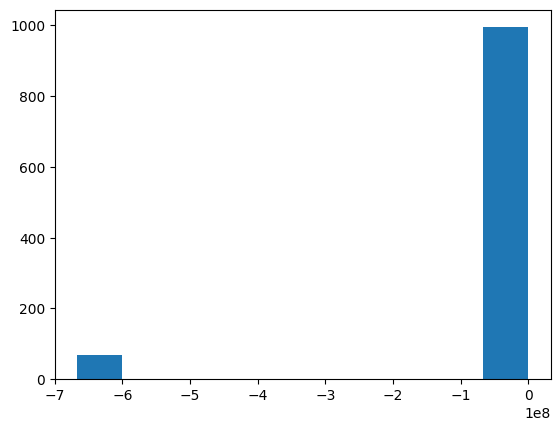

In [75]:
plt.hist(income_data['B19013_001E'])
plt.show()

Seems like there are some negative values which indicate they could be missing values. In a serious study, we should dig more deeper on why they are like that. For now, we can simply replace the data to the mean of the income data. We will do that in ArcGIS. For now, let's replace these to 

In [77]:
# problematic rows
income_data[income_data['B19013_001E'] < -1]

,B19013_001E,NAME,state,county,tract,block group
5,-666666666,"Block Group 5, Census Tract 2104, St. Louis Co...",29,189,210400,5
47,-666666666,"Block Group 3, Census Tract 2127.02, St. Louis...",29,189,212702,3
56,-666666666,"Block Group 1, Census Tract 2137.01, St. Louis...",29,189,213701,1
60,-666666666,"Block Group 1, Census Tract 2139, St. Louis Co...",29,189,213900,1
97,-666666666,"Block Group 2, Census Tract 2161.01, St. Louis...",29,189,216101,2
...,...,...,...,...,...,...
909,-666666666,"Block Group 3, Census Tract 2195.01, St. Louis...",29,189,219501,3
988,-666666666,"Block Group 2, Census Tract 2208.01, St. Louis...",29,189,220801,2
1005,-666666666,"Block Group 1, Census Tract 2213.35, St. Louis...",29,189,221335,1
1010,-666666666,"Block Group 2, Census Tract 2213.36, St. Louis...",29,189,221336,2


In [80]:
income_data.loc[income_data['B19013_001E'] < 1, 'B19013_001E'] = np.nan

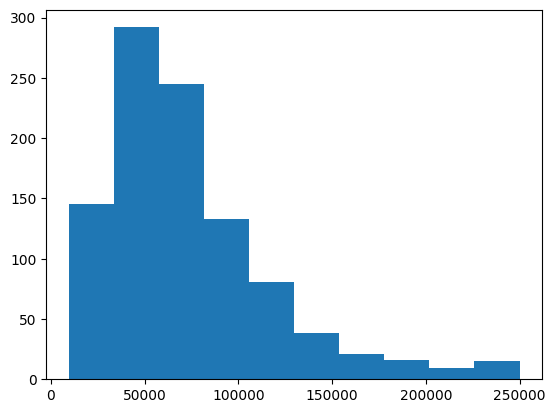

In [81]:
plt.hist(income_data['B19013_001E'])
plt.show()

In [82]:
# create geoid column that can be matched with the block group shapefile
income_data['geoid'] = income_data['state']+income_data['county']+income_data['tract']+income_data['block group']

In [83]:
income_data.head()

,B19013_001E,NAME,state,county,tract,block group,geoid
0,25321.0,"Block Group 1, Census Tract 2101.02, St. Louis...",29,189,210102,1,291892101021
1,34471.0,"Block Group 1, Census Tract 2102, St. Louis Co...",29,189,210200,1,291892102001
2,30676.0,"Block Group 4, Census Tract 2102, St. Louis Co...",29,189,210200,4,291892102004
3,47806.0,"Block Group 3, Census Tract 2103, St. Louis Co...",29,189,210300,3,291892103003
4,66271.0,"Block Group 2, Census Tract 2104, St. Louis Co...",29,189,210400,2,291892104002


Now we need to connect the income data with block group shapefile. The block group shapefile was downloaded from [https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341).

In [84]:
# read the block group shapefile
block_group_shape = gpd.read_file('labs/lab-2/data/shapes/tl_2022_29_bg/tl_2022_29_bg.shp')

In [85]:
block_group_shape.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,29,049,960300,3,290499603003,Block Group 3,G5030,S,8119973,66702,+39.5540627,-094.4676162,"POLYGON ((-94.49062 39.54373, -94.49062 39.543..."
1,29,049,960400,2,290499604002,Block Group 2,G5030,S,11311135,0,+39.6103319,-094.5847601,"POLYGON ((-94.60214 39.62571, -94.60182 39.625..."
2,29,049,960100,2,290499601002,Block Group 2,G5030,S,703682,0,+39.7439712,-094.2454139,"POLYGON ((-94.25313 39.74314, -94.25312 39.744..."
3,29,510,127700,2,295101277002,Block Group 2,G5030,S,593877,0,+38.6530839,-090.2324689,"POLYGON ((-90.23843 38.65102, -90.23821 38.651..."
4,29,510,127700,1,295101277001,Block Group 1,G5030,S,317648,0,+38.6577982,-090.2302324,"POLYGON ((-90.23499 38.657, -90.23487 38.65716..."


In [86]:
# join the median income data with the block group data
block_group_shape_income = pd.merge(
    block_group_shape,
    income_data,
    how='right',
    left_on='GEOID',
    right_on='geoid'
)

In [87]:
block_group_shape_income.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,B19013_001E,NAME,state,county,tract,block group,geoid
0,29,189,210102,1,291892101021,Block Group 1,G5030,S,1702667,0,+38.7712358,-090.1974637,"POLYGON ((-90.20868 38.76792, -90.20865 38.768...",25321.0,"Block Group 1, Census Tract 2101.02, St. Louis...",29,189,210102,1,291892101021
1,29,189,210200,1,291892102001,Block Group 1,G5030,S,1373364,0,+38.7585935,-090.2122044,"POLYGON ((-90.21972 38.75024, -90.21948 38.753...",34471.0,"Block Group 1, Census Tract 2102, St. Louis Co...",29,189,210200,1,291892102001
2,29,189,210200,4,291892102004,Block Group 4,G5030,S,328382,0,+38.7532603,-090.1984372,"POLYGON ((-90.20417 38.75111, -90.20388 38.751...",30676.0,"Block Group 4, Census Tract 2102, St. Louis Co...",29,189,210200,4,291892102004
3,29,189,210300,3,291892103003,Block Group 3,G5030,S,632819,0,+38.7451885,-090.2082257,"POLYGON ((-90.21443 38.74357, -90.21419 38.745...",47806.0,"Block Group 3, Census Tract 2103, St. Louis Co...",29,189,210300,3,291892103003
4,29,189,210400,2,291892104002,Block Group 2,G5030,S,292130,0,+38.7275057,-090.2367080,"POLYGON ((-90.23998 38.72887, -90.23976 38.728...",66271.0,"Block Group 2, Census Tract 2104, St. Louis Co...",29,189,210400,2,291892104002


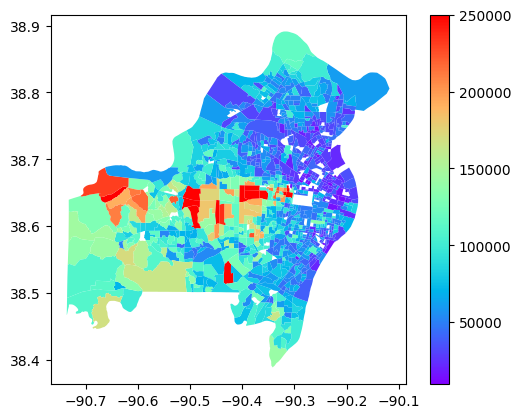

In [88]:
# choropleth map of median income
block_group_shape_income.plot(column='B19013_001E', cmap='rainbow', legend=True)
plt.show()

In [89]:
block_group_shape_income.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'B19013_001E', 'NAME', 'state', 'county', 'tract',
       'block group', 'geoid'],
      dtype='object')

In [90]:
# select specific columns from the data
block_group_shape_income = block_group_shape_income[
    [
        'GEOID','geometry', 'B19013_001E', 'NAME', 
        'state', 'county', 'tract', 'block group'
    ]
]

In [91]:
# rename some columns
block_group_shape_income = block_group_shape_income.rename(
    columns={
        'B19013_001E': 'income',
        'block group': 'block_grp'
    }
)

## Save the shapes

Make sure the crs of the shapes are in projected coordinate system. We will use the UTM 15N zone (EPSG: 32615).

In [56]:
crime_data_proj = crime_data.to_crs('EPSG: 32615')

In [57]:
liquors = liquors.to_crs('EPSG: 32615')

In [92]:
block_group_shape_income = block_group_shape_income.to_crs('EPSG: 32615')

In [63]:
os.makedirs('labs/lab-2/data/shapes/crime_data')
crime_data_proj.to_file('labs/lab-2/data/shapes/crime_data/crime_data.shp')

In [64]:
os.makedirs('labs/lab-2/data/shapes/liquors')
liquors.to_file('labs/lab-2/data/shapes/liquors/liquors.shp')

In [94]:
os.makedirs('labs/lab-2/data/shapes/income')
block_group_shape_income.to_file('labs/lab-2/data/shapes/income/income.shp')